# Time Series Prediction with Multilayer Perceptrons

Time Series prediction is a difficult problem both to frame and to address with machine learning. In this lesson, you will discover how to develop neural network models for time series prediction in Python using the Keras deep learning library. After reading this lesson, you will know:
* About the airline passengers' univariate time series prediction problem.
* How to phrase time series prediction as a regression problem and develop a neural network model for it.
* How to frame time series prediction with a time lag and develop a neural network model for it.

Let's get started.

## Problem Description: Time Series Prediction

The problem we are going to look at in this lesson is the international airline passengers prediction problem. This is a problem where given a year, and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations. The dataset is in a file named `airline passengers.csv` and it can be found in the `datasets` folder. Below is a sample of the first few lines of the file.

In [1]:
import pandas as pd

dataset = pd.read_csv('../../datasets/airline-passengers.csv')
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


We can load this dataset easily using the Pandas library. We are not interested in the date, given that each observation is separated by the same interval of one month. Therefore when we load the dataset, we can exclude the first column. Once loaded, we can easily plot the whole dataset. The code to load and plot the dataset is listed below.

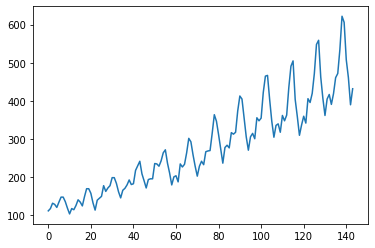

In [2]:
import matplotlib.pyplot as plt

dataset = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

You can see an upward trend in the plot. You can also see some periodicity to the dataset that probably corresponds to the northern hemisphere summer holiday period.

We are going to keep things simple and work with the data as-is. Normally, it is a good idea to investigate various data preparation techniques to rescale the data and make it stationary.

## Multilayer Perceptron Regression

We will phrase the time series prediction problem as a regression problem. Given the number of passengers (in units of thousands) this month, what is the number of passengers next month? We can write a simple function to convert our single column of data into a two-column dataset. The first column containing this month's (`t`) passenger count, and the second column containing next month's (`t+1`) passenger count, to be predicted. Before we get started, let's first import all of the functions and classes we intend to use.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# fix random seed for reproducibility
np.random.seed(7)

We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating-point values, which are more suitable for modeling with a neural network.

In [4]:
# load the dataset
dataframe = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using k-fold cross-validation. With time-series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

96 48


Now we can define a function to create a new dataset as described above. The function takes two arguments, the dataset, which is a NumPy array that we want to convert into a dataset, and the look back, which is the number of previous time steps to use as input variables to predict the next time period, in this case, defaulted to 1. This default will create a dataset where X is the number of passengers at a given time (`t`), and Y is the number of passengers at the next time (`t+1`). It can be configured, and we will construct a differently shaped dataset in the next section.

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

Let's take a look at the effect of this function on the first few rows of the dataset.

In [7]:
x, y = create_dataset(dataset)
df = pd.DataFrame({'X': x.flatten(), 'Y':y})
df.head()

,X,Y
0,112.0,118.0
1,118.0,132.0
2,132.0,129.0
3,129.0,121.0
4,121.0,135.0


If you compare these first five rows to the original dataset sample listed in the previous section, you can see the `X=t` and `Y=t+1` patterns in the numbers. Let's use this function to prepare the train and test datasets ready for modeling.

In [8]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

We can now fit a Multilayer Perceptron model to the training data. We use a simple network with one input, one hidden layer with eight neurons, and an output layer. The model is fit using mean squared error. If we take the square root gives us an error score in the units of the dataset. We tried a few rough parameters and settled on the configured below, but the network listed optimized by no means.

In [9]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
47/47 - 1s - loss: 51748.0391
Epoch 2/200
47/47 - 0s - loss: 51085.0000
Epoch 3/200
47/47 - 0s - loss: 50744.2656
Epoch 4/200
47/47 - 0s - loss: 50672.4805
Epoch 5/200
47/47 - 0s - loss: 50653.0469
Epoch 6/200
47/47 - 0s - loss: 50633.5117
Epoch 7/200
47/47 - 0s - loss: 50614.1133
Epoch 8/200
47/47 - 0s - loss: 50594.5586
Epoch 9/200
47/47 - 0s - loss: 50575.1523
Epoch 10/200
47/47 - 0s - loss: 50555.6172
Epoch 11/200
47/47 - 0s - loss: 50536.2031
Epoch 12/200
47/47 - 0s - loss: 50516.7695
Epoch 13/200
47/47 - 0s - loss: 50497.1797
Epoch 14/200
47/47 - 0s - loss: 50477.8398
Epoch 15/200
47/47 - 0s - loss: 50458.3281
Epoch 16/200
47/47 - 0s - loss: 50438.8516
Epoch 17/200
47/47 - 0s - loss: 50419.4141
Epoch 18/200
47/47 - 0s - loss: 50399.9805
Epoch 19/200
47/47 - 0s - loss: 50380.5273
Epoch 20/200
47/47 - 0s - loss: 50361.0586
Epoch 21/200
47/47 - 0s - loss: 50341.6367
Epoch 22/200
47/47 - 0s - loss: 50322.1875
Epoch 23/200
47/47 - 0s - loss: 50302.7930
Epoch 24/200
47/47 -

Epoch 190/200
47/47 - 0s - loss: 47123.4883
Epoch 191/200
47/47 - 0s - loss: 47104.9531
Epoch 192/200
47/47 - 0s - loss: 47086.3867
Epoch 193/200
47/47 - 0s - loss: 47067.6875
Epoch 194/200
47/47 - 0s - loss: 47049.0898
Epoch 195/200
47/47 - 0s - loss: 47030.3398
Epoch 196/200
47/47 - 0s - loss: 47011.8242
Epoch 197/200
47/47 - 0s - loss: 46993.2031
Epoch 198/200
47/47 - 0s - loss: 46974.5391
Epoch 199/200
47/47 - 0s - loss: 46955.9375
Epoch 200/200
47/47 - 0s - loss: 46937.3555


Once the model is fit, we can estimate the model's performance on the train and test datasets. This will give us a point of comparison for new models.

In [10]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 46927.63 MSE (216.63 RMSE)
Test Score: 170996.98 MSE (413.52 RMSE)


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the model's skill. Because of how the dataset was prepared, we must shift the predictions to align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the train dataset in green the predictions on the unseen test dataset in red.

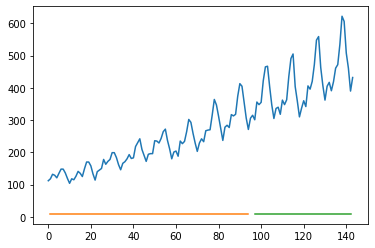

In [11]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the model did a pretty poor job of fitting both the training and the test datasets. It predicted the same input value as the output. The plot makes the prediction look good, but in fact, the shift in the prediction results in a poor skill score.

Taking the square root of the performance estimates, we can see that the model has an average error of 23 passengers (in thousands) on the training dataset and 48 passengers (in thousands) on the test dataset.

## Multilayer Perceptron Using the Window Method

We can also phrase the problem so that multiple recent time steps can be used to predict the next time step. This is called the window method, and the size of the window is a parameter that can be tuned for each problem. For example, given the current time (`t`), we want to predict the value at the next time in the sequence (`t+1`), we can use the current time (t) as well as the two prior times (`t-1` and `t-2`). When phrased as a regression problem, the input variables are `t-2`, `t-1`, `t`, and the output variable is `t+1`.

The `create_dataset()` function we wrote in the previous section allows us to create this formulation of the time series problem by increasing the look-back argument from 1 to 3. A sample of the dataset with this formulation looks as follows:

In [12]:
x, y = create_dataset(dataset, look_back = 3)
df = pd.DataFrame(np.column_stack((x,y)), columns=['X1', 'X2', 'X3', 'Y'])
df.head()

,X1,X2,X3,Y
0,112.0,118.0,132.0,129.0
1,118.0,132.0,129.0,121.0
2,132.0,129.0,121.0,135.0
3,129.0,121.0,135.0,148.0
4,121.0,135.0,148.0,148.0


We can re-run the example in the previous section with the larger window size. We will increase the network capacity to handle the additional information. The first hidden layer is increased to 14 neurons, and a second hidden layer is added with eight neurons. The number of epochs is also increased to 400.

Running the example provides the following output.

In [13]:
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/400
46/46 - 0s - loss: 3591.2075
Epoch 2/400
46/46 - 0s - loss: 1203.6779
Epoch 3/400
46/46 - 0s - loss: 1096.8320
Epoch 4/400
46/46 - 0s - loss: 927.9024
Epoch 5/400
46/46 - 0s - loss: 843.2300
Epoch 6/400
46/46 - 0s - loss: 788.1057
Epoch 7/400
46/46 - 0s - loss: 748.6956
Epoch 8/400
46/46 - 0s - loss: 749.5067
Epoch 9/400
46/46 - 0s - loss: 697.7549
Epoch 10/400
46/46 - 0s - loss: 739.5781
Epoch 11/400
46/46 - 0s - loss: 634.3849
Epoch 12/400
46/46 - 0s - loss: 615.8271
Epoch 13/400
46/46 - 0s - loss: 619.8929
Epoch 14/400
46/46 - 0s - loss: 646.3306
Epoch 15/400
46/46 - 0s - loss: 585.7032
Epoch 16/400
46/46 - 0s - loss: 570.9921
Epoch 17/400
46/46 - 0s - loss: 564.7935
Epoch 18/400
46/46 - 0s - loss: 565.6684
Epoch 19/400
46/46 - 0s - loss: 536.9590
Epoch 20/400
46/46 - 0s - loss: 581.2353
Epoch 21/400
46/46 - 0s - loss: 541.7184
Epoch 22/400
46/46 - 0s - loss: 530.7318
Epoch 23/400
46/46 - 0s - loss: 519.2506
Epoch 24/400
46/46 - 0s - loss: 523.1961
Epoch 25/400
46/46 - 0

Epoch 199/400
46/46 - 0s - loss: 469.5807
Epoch 200/400
46/46 - 0s - loss: 459.1345
Epoch 201/400
46/46 - 0s - loss: 474.8500
Epoch 202/400
46/46 - 0s - loss: 440.7276
Epoch 203/400
46/46 - 0s - loss: 467.9614
Epoch 204/400
46/46 - 0s - loss: 518.0838
Epoch 205/400
46/46 - 0s - loss: 456.7194
Epoch 206/400
46/46 - 0s - loss: 440.8198
Epoch 207/400
46/46 - 0s - loss: 458.1613
Epoch 208/400
46/46 - 0s - loss: 485.1669
Epoch 209/400
46/46 - 0s - loss: 489.6052
Epoch 210/400
46/46 - 0s - loss: 461.4280
Epoch 211/400
46/46 - 0s - loss: 455.8094
Epoch 212/400
46/46 - 0s - loss: 452.7388
Epoch 213/400
46/46 - 0s - loss: 463.1684
Epoch 214/400
46/46 - 0s - loss: 487.2332
Epoch 215/400
46/46 - 0s - loss: 485.9392
Epoch 216/400
46/46 - 0s - loss: 448.0785
Epoch 217/400
46/46 - 0s - loss: 446.7669
Epoch 218/400
46/46 - 0s - loss: 461.2694
Epoch 219/400
46/46 - 0s - loss: 450.8848
Epoch 220/400
46/46 - 0s - loss: 446.1081
Epoch 221/400
46/46 - 0s - loss: 468.2625
Epoch 222/400
46/46 - 0s - loss: 4

46/46 - 0s - loss: 470.0864
Epoch 395/400
46/46 - 0s - loss: 457.3257
Epoch 396/400
46/46 - 0s - loss: 476.0947
Epoch 397/400
46/46 - 0s - loss: 423.0691
Epoch 398/400
46/46 - 0s - loss: 432.1806
Epoch 399/400
46/46 - 0s - loss: 437.2089
Epoch 400/400
46/46 - 0s - loss: 443.7492
Train Score: 412.97 MSE (20.32 RMSE)
Test Score: 1784.30 MSE (42.24 RMSE)


We can see that the error was reduced compared to that of the previous section. Again, the window size and the network architecture were not tuned. This is just a demonstration of how to frame a prediction problem. Taking the square root of the performance scores, we can see the average error on the training dataset was 20 passengers (in thousands per month), and the average error on the unseen test set was 42 passengers (in thousands per month).

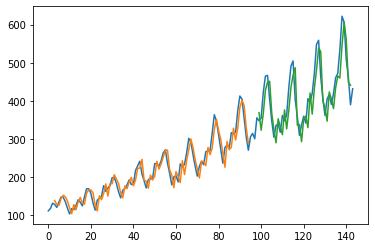

In [14]:
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Summary

In this lesson, you discovered how to develop a neural network model for a time series prediction problem using the Keras deep learning library. After working through this tutorial, you now know:

* About the international airline passenger prediction time series dataset.
* How to frame time series prediction problems as regression problems and develop a neural network model.
* How to use the window approach to frame a time series prediction problem and develop a neural network model.